In [221]:
# @title Autor: Alan Echer
# O algoritmo abaixo foi criado baseado nas funcoes apreendidas na aula de
# IA e machine learning do INFNET

# passos para fazer ao analisar os dados
#adicionar dependencias
#carregar os dados dos dataset
#analisar de dados
#normalizar dados das colunas
#verificar dados nullos
#verificar dados categoricos
#verificar representatividade dos dados do objetivo em relação ao restante dos dados
#(objetivo = 1, restante = 0)
#normalizar os dados
#verificar separabilidade linear
#separar os dados treino / teste estratificando
#definir o baseline otimista / pessimista
#gerar os dados estatisticos
#otimizacao verificar os falsos positivos e falsos negativos em funcao do limiar minimo
#otimizacao verificar o precisao e recall em funcao do limiar minimo
#otimizacao verificar curva ROC vs classificador aleatorio
#otimizacao lucro medio em relacao ao limiar minimo
#gerar o modelo e os dados estatisticos
#comparar com os modelos otimista e pessimistas

In [222]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive

# ignorar warnings
warnings.filterwarnings('ignore')

In [223]:
# o codigo abaixo sao todas as funcoes utilizadas pelo algoritmo para tratar e analisar os dados, nao devem ser alteradas

def loadAnaliseAndTransformData(cache, configuration, y_column):
  data = loadDataSetFromGDriveOrCache(cache, configuration)

  reAddDroppedColumnsBefore(configuration, cache, data)

  if(configuration['normalize_columns']['enabled']):
    print()
    print('=> Normalizing column names...')
    normalizeColumnNames(configuration, data)
    print('=> Normalizing column names... OK')

  transformData(configuration, cache, data)

  if(configuration['drop_columns']['enabled']):
    print()
    print('=> Dropping columns...')
    dropColumns(configuration, cache, data)
    print('=> Dropping columns... OK')

  if(configuration['dataset']['show_data']['enabled']):
    showDataInfo(configuration, data)

  if(data.get(y_column) is None):
    print('=> ERROR: Y column not found on dataset: ', y_column)
    print('=> ERROR: ABORTING...OK')
    return

  if(configuration['confusion_matrix']['enabled']):
    print()
    print('=> Generating confusion matrix...')
    generateConfusionMatrix(configuration, data, y_column)
    print('=> Generating confusion matrix... OK')

  if(configuration['pair_plot']['enabled']):
    print()
    print('=> Plotting pair plot...')
    plotPairPlot(configuration, data)
    print('=> Plotting pair plot... OK')

  if(configuration['proportion_plot']['enabled']):
    print()
    print('=> Plotting proportions...')
    proportionPlot(configuration, data)
    print('=> Plotting proportions... OK')

  return data

def loadDataSetFromGDriveOrCache(cache, configuration):
  if(cache['dataset'] is None):
    if(configuration['dataset']['source_provider'] == 'gdrive'):
      print('=> Mounting google drive...')
      drive.mount('/content/drive')
      print('=> Mounting google drive... OK')
    else:
      print('=> ERROR: Source provider not supported: '+configuration['dataset']['source_provider'])
      return

    if(configuration['dataset']['reader_type'] == 'csv'):
      print()
      print('=> Reading csv data...')
      cache['dataset'] = pd.read_csv('/content/drive/MyDrive/'+configuration['dataset']['path'], sep=configuration['dataset']['sep'])
      print('=> Reading csv data... OK')
      return cache['dataset']
    else:
      print('=> ERROR: Reader type not supported: '+configuration['dataset']['reader_type'])
      return
  else:
    print()
    print('=> Using cached dataset... OK')
  return cache['dataset']

def showDataInfo(configuration, data):
  if(configuration['dataset']['show_data']['dataset_head']):
    print()
    print('=> Dataset head: ')
    print(data.head())

  if(configuration['dataset']['show_data']['dataset_info']):
    print()
    print('=> Dataset info: ')
    print(data.info())

  if(configuration['dataset']['show_data']['dataset_describe']):
    print()
    print('=> Dataset describe: ')
    print(data.describe())

  if(configuration['dataset']['show_data']['dataset_nulls']):
    print()
    print('=> Dataset nulls: ')
    print(data.isnull().sum())

  if(configuration['dataset']['show_data']['dataset_duplicated']):
    print()
    print('=> Dataset duplicated: ')
    print(data.duplicated().sum())

  if(configuration['dataset']['show_data']['dataset_unique_values']):
    print()
    print('=> Dataset unique values: ')
    for column in data.columns:
      print()
      print('=> Column: '+column, data[column].unique())

  if(configuration['dataset']['show_data']['dataset_value_counts']):
    print()
    print('=> Dataset value counts: ')
    for column in data.columns:
      print()
      print('=> Column: ', data[column].value_counts(normalize=True))
  pass

def transformData(configuration, cache, data):
  for transformation in configuration['data_transformation']['transformations']:
    columnName = transformation['column']
    #backup original data column for cenarios where you need to run transformation multiple times
    #and not want to loose original data
    cachedColumns = cache['original_data_before_transformation']
    if(not transformation['enabled']):
      if(cachedColumns.get(columnName) is not None):
        data[columnName] = cachedColumns[columnName]
      continue
    print()
    print()
    print('=> Applying data transformations...')
    if(cachedColumns.get(columnName) is None):
      cachedColumns[columnName] = data[columnName]
    if(transformation['transform_to_new_column']['enabled']):
      data[transformation['transform_to_new_column']['name']] = data[columnName].apply(transformation['function'])
    else:
      data[columnName] = cachedColumns[columnName].apply(transformation['function'])
    print('=> Applying data transformations... OK')
  pass

def normalizeColumnNames(configuration, data):
  normalize = configuration['normalize_columns']
  if(normalize['modificator'] == 'lower'):
    data.columns = data.columns.str.lower()
  elif(normalize['modificator'] == 'upper'):
    data.columns = data.columns.str.upper()
  else:
    print('=> ERROR: modificator unsuported!')
  for column in data.columns:
    for replacement in normalize['replacements']:
      data.columns = data.columns.str.replace(replacement['char_to_replace'], replacement['replace_with'])
  pass

def reAddDroppedColumnsBefore(configuration, cache, data):
  columns = []
  for column in cache['original_data_before_drop']:
    if(cache['original_data_before_drop'].get(column) is not None):
      print()
      print('=> Recriando coluna previamente deletada: ', column)
      data[column] = cache['original_data_before_drop'][column]
      columns.append(column)
      print('=> Recriando coluna previamente deletada... OK')
  for column in columns:
     print()
     print('=> Apagando coluna restaurada do cache: ', column)
     del cache['original_data_before_drop'][column]
     print('=> Apagando coluna restaurada do cache... OK')
  pass

def dropColumns(configuration, cache, data):
  for column in configuration['drop_columns']['columns']:
    cache['original_data_before_drop'][column] = data[column]
  return data.drop(columns=configuration['drop_columns']['columns'], inplace=True)

def checkColumnTypesAreNumbers(data, columns):
  invalidColumns=[]
  for column in columns:
    for value in data[column].unique():
      try:
        float(value)
      except ValueError:
        print()
        print('=> ERROR: this column cannot be used to pair plot because it not have numerical values: ', column)
        print('=> ERROR: value: ', value)
        invalidColumns.append(column)
        break
  for column in invalidColumns:
    print()
    print('=> Removing invalid column for pair plot: ', column)
    columns.remove(column)
  pass

def plotPairPlot(configuration, data):
  if(configuration['pair_plot']['type'] == '2d'):
    hue = hue=configuration['pair_plot']['hue_column']
    if(configuration['pair_plot']['columns'] == 'all'):
      columns = []
      for column in data.columns:
        columns.append(column)
      print()
      print('=> Plotting pair plot with all columns: ', columns)
      checkColumnTypesAreNumbers(data, columns)
      sns.pairplot(data=data, hue=hue)
    elif (configuration['pair_plot']['columns'] == 'selection'):
      selection = configuration['pair_plot']['selection']
      if(hue not in selection):
        selection.append(hue)
      checkColumnTypesAreNumbers(data, selection)
      data_to_plot = data.loc[:,selection]
      print()
      print('=> Plotting pair plot with columns: ', selection)
      sns.pairplot(data=data_to_plot, hue=hue)
    else:
      print('=> ERROR: Pair plot columns not supported: '+configuration['pair_plot']['columns'])
      return
  else:
    print('=> ERROR: Pair plot type not supported: '+configuration['pair_plot']['type'])
    return
  pass

def generateConfusionMatrix(configuration, data, y_column):
  unique_values = data[y_column].unique()
  if(len(unique_values) == 2):
    if((unique_values[0] == 1 or unique_values[0] == 0) and (unique_values[1] == 1 or unique_values[1] == 0)):
      x, y = splitXY(data, y_column)
      x_train, x_test, y_train, y_test = splitTrainTest(x, y, configuration['dataset']['proportion_of_test'])
      y_optimist = [0] * len(y_test)
      y_pessimist = [1] * len(y_test)

      print()
      print('=> Imprimindo matriz de confusão otimista (0)')
      printConfusionMatrix(y_test, y_optimist)
      print()
      print('=> Imprimindo metricas do modelo otimista... (0)')
      printMetricsOfModel(y_test, y_optimist)
      print()
      print('=> Imprimindo matriz de confusão pessimista (1)')
      printConfusionMatrix(y_test, y_pessimist)
      print()
      print('=> Imprimindo metricas do modelo pessimista... (1)')
      printMetricsOfModel(y_test, y_pessimist)


    else:
      print('=> ERROR: Y column has following values: ', unique_values)
      print('=> ERROR: Y column must contain only two values: 0, 1')
  else:
    print('=> ERROR: Y column has following values: ', unique_values)
    print('=> ERROR: Y column must contain only two values: 0, 1')
  pass

def printConfusionMatrix(data, y_optimist):
  print()
  cm = confusion_matrix(data[y_column], y_optimist)
  labels = np.array([["TN[{}]".format(cm[0,0]), "FP[{}]".format(cm[0,1])],
                   ["FN[{}]".format(cm[1,0]), "TP[{}]".format(cm[1,1])]])
  sns.heatmap(cm,  annot=labels, fmt='', cmap="Blues")
  plt.title('Matriz de Confusão - Regressão Logistica')
  plt.xlabel('Saida do Modelo')
  plt.ylabel('Saida Esperada')
  plt.tight_layout()
  plt.show()
  pass

def proportionPlot(configuration, data):
  if(configuration['proportion_plot']['columns'] == 'all'):
    for column in data.columns:
      proportionPlotGraphic(data, configuration, column)
  elif (configuration['proportion_plot']['columns'] == 'selection'):
    for selection in configuration['proportion_plot']['selection']:
      if(selection['enabled']):
        proportionPlotGraphic(data, configuration, selection['column'])
  else:
    print('=> ERROR: Pair plot columns not supported: '+configuration['pair_plot']['columns'])
    return
  pass

def proportionPlotGraphic(data, configuration, column):
  print()
  print("=> Ploting proportion for column: ", column)
  proportions = data[column].value_counts(normalize=True)
  plt.bar(x=proportions.index, height=proportions.values)
  plt.title('Proporção de valores da coluna: '+column)
  plt.show()
  pass

def splitXY(data, y_column):
  x = data.drop(columns=[y_column])
  y = data[[y_column]]
  return x, y

def splitTrainTest(x, y, proportion_for_test):
  return train_test_split(x, y, test_size=proportion_for_test, stratify=y)

def printMetricsOfModel(y_test, y_base):
  print(classification_report(y_test, y_base))

In [224]:
# as variaveis abaixo mantem o cache de alguns dados antes das transformacoes,
# drops ou carregamento do gdrive para melhorias de performance e integridade
# das informacoes quando sao feitas execucoes de codigo parciais no colab
cache = {
    'dataset':None,
    'original_data_before_transformation':{},
    'original_data_before_drop':{},
}

=> Mounting google drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=> Mounting google drive... OK

=> Reading csv data...
=> Reading csv data... OK

=> Normalizing column names...
=> Normalizing column names... OK


=> Applying data transformations...
=> Applying data transformations... OK

=> Dataset head: 
    type  fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free_sulfur_dioxide  total_sulfur_dioxide  density    ph  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      

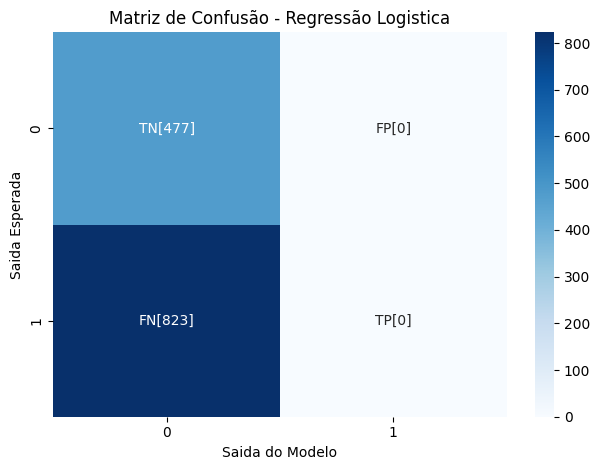


=> Imprimindo metricas do modelo otimista... (0)
              precision    recall  f1-score   support

           0       0.37      1.00      0.54       477
           1       0.00      0.00      0.00       823

    accuracy                           0.37      1300
   macro avg       0.18      0.50      0.27      1300
weighted avg       0.13      0.37      0.20      1300


=> Imprimindo matriz de confusão pessimista (1)



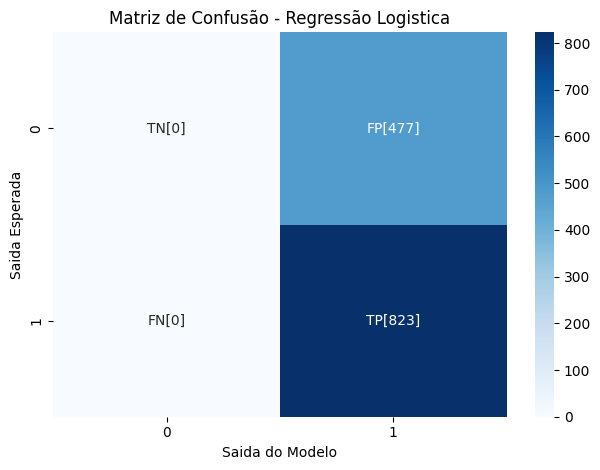


=> Imprimindo metricas do modelo pessimista... (1)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       477
           1       0.63      1.00      0.78       823

    accuracy                           0.63      1300
   macro avg       0.32      0.50      0.39      1300
weighted avg       0.40      0.63      0.49      1300

=> Generating confusion matrix... OK

=> Plotting proportions...

=> Ploting proportion for column:  opinion


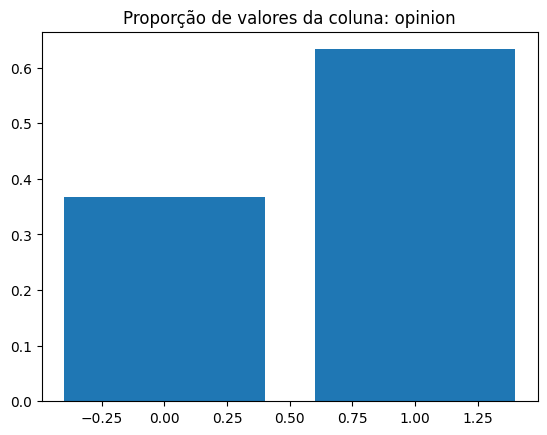

=> Plotting proportions... OK


In [225]:
# Esta é a configuracao inicial nela voce irá alterar as variaveis para que
# sua analise seja feita corretamente, nao se preocupe com a quantidade de
# informacao e nem no que será colocado em cada campo neste momento
# pois a maioria dos trechos estao desabilitados 'enabled': False entao nao
# serao executados.

# 1. Comece pela seção dataset, informando sua fonte de dados de acordo com os
# comentarios.

# 1.2. Na seção show_data será possível exibir os dados do dataset carregado.

# Somente com essas duas seções preenchidas já será possível executar o codigo
# e verificar os dados carregados no dataset.

# 2. Na seção normalize_columns será possível transformar as colunas
# substituindo caracteres.

# 3. Na seção data_transformation será possível transformar os dados das linhas
# atraves de uma função lambda que retornará o novo dado baseado na sua logica.

# 4. Na seção drop_columns será possível excluir algumas colunas do dataset.

# 5. Na seção pair_plot será possível configurar a plotagem dos pares para
# analise da separabilidade linear.
# (Não esqueça de preencher a variavel 'y_column')

# 6. Na seção confusion_matrix será possível configurar a plotagem da matrix de
# confusão.
# (Não esqueça de preencher a variavel 'y_column')

y_column = "opinion"

configuration = {
    "show_debug_info": True,  # TODO implementar nivel de log
    "dataset": {
        "source_provider": "gdrive",  # only supported google drive
        "reader_type": "csv",  # only supported csv
        "path": "ALGORITMOS DE IA/DATASET/winequalityN.csv",  # CAMINHO PARA O SEU DATASET NO GDRIVE
        "sep": ",",  # SEPARADOR DOS DADOS DO SEU DATASET, POR EX: , OU ; OU OUTRO
        "show_data": {  # SECAO PARA CONFIGURACAO DOS LOGS
            "enabled": True,
            "dataset_head": True,
            "dataset_info": True,
            "dataset_describe": False,
            "dataset_nulls": True,
            "dataset_duplicated": True,
            "dataset_unique_values": False,
            "dataset_value_counts": True,
        },
        "proportion_of_test": 0.2,  # PERCENTUAL DO DATASET PARA SER USADO NO TREINO / TESTE
    },
    "normalize_columns": {  # SECAO PARA CONFIGURACAO DA NORMALIZACAO DAS COLUNAS
        "enabled": True,
        "modificator": "lower",  # ALLOWED ONLY 'lower' or 'upper' value
        "replacements": [
            {"char_to_replace": " ", "replace_with": "_"},
            {"char_to_replace": "(", "replace_with": ""},
            {"char_to_replace": ")", "replace_with": ""},
        ],
    },
    "data_transformation": {  # SECAO PARA CONFIGURACAO DA TRANSFORMACAO DOS DADOS
        "transformations": [
            {
                "enabled": True,
                "column": "quality",
                "function": lambda r: 1 if r > 5 else 0,
                "transform_to_new_column":{
                    "enabled": True,
                    "name": "opinion"
                }
            },
        ]
    },
    "drop_columns": {
        "enabled": False,
        "columns": []
    },
    "pair_plot": {
        "enabled": False,
        "type": "2d",  # only 2d available
        "columns": "all",  # all or selection
        "selection": [],
        "hue_column": y_column,
    },
    "confusion_matrix": {
        "enabled": True,
        "generate_optimist": True,
        "generate_pessimist": True,
    },
    "proportion_plot":{
        "enabled": True,
        "columns": "selection",  # all or selection
        "selection":[
            {
                "enabled": True,
                "column": y_column,
            }
        ],
    }
}

data = loadAnaliseAndTransformData(cache, configuration, y_column)


Olá, Alan,

Nessa disciplina, aprendemos nossos conhecimentos em algoritmos supervisionados, família de algoritmos que é extremamente importante para o dia-a-dia de um cientista de dados. Agora iremos validar nosso conhecimento.

Faça o módulo do Kaggle Intro to Machine Learning:
Comprove a finalização do módulo com um print que contenha data e identificação do aluno.

Trabalho com base:

Iremos usar a base de dados de vinhos verdes portugueses (nas variantes branco e tinto) que encontra-se disponível no Kaggle:

Para as questões 2-5 usaremos apenas os vinhos do tipo "branco".

Faça o download da base - esta é uma base real, apresentada no artigo:
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Ela possui uma variável denominada "quality", uma nota de 0 a 10 que denota a qualidade do vinho. Crie uma nova variável, chamada "opinion" que será uma variável categórica igual à 0, quando quality for menor e igual à 5. O valor será 1, caso contrário. Desconsidere a variável quality para o restante da análise.

Descreva as variáveis presentes na base. Quais são as variáveis? Quais são os tipos de variáveis (discreta, categórica, contínua)? Quais são as médias e desvios padrões?

Com a base escolhida:

Descreva as etapas necessárias para criar um modelo de classificação eficiente.

Treine um modelo de regressão logística usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação. Calcule para a base de teste:
i. a média e desvio da acurácia dos modelos obtidos;
ii. a média e desvio da precisão dos modelos obtidos;
iii. a média e desvio da recall dos modelos obtidos;
iv. a média e desvio do f1-score dos modelos obtidos.

Treine um modelo de árvores de decisão usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação. Calcule para a base de teste:
i. a média e desvio da acurácia dos modelos obtidos;
ii. a média e desvio da precisão dos modelos obtidos;
iii. a média e desvio da recall dos modelos obtidos;
iv. a média e desvio do f1-score dos modelos obtidos.

Treine um modelo de SVM usando um modelo de validação cruzada estratificada com k-folds (k=10) para realizar a classificação. Calcule para a base de teste:
i. a média e desvio da acurácia dos modelos obtidos;
ii. a média e desvio da precisão dos modelos obtidos;
iii. a média e desvio da recall dos modelos obtidos;
iv. a média e desvio do f1-score dos modelos obtidos.

Em relação à questão anterior, qual o modelo deveria ser escolhido para uma eventual operação. Responda essa questão mostrando a comparação de todos os modelos, usando um gráfico mostrando a curva ROC média para cada um dos gráficos e justifique.

Com a escolha do melhor modelo, use os dados de vinho tinto, presentes na base original e faça a inferência (não é para treinar novamente!!!) para saber quantos vinhos são bons ou ruins. Utilize o mesmo critério utilizado com os vinhos brancos, para comparar o desempenho do modelo. Ele funciona da mesma forma para essa nova base? Justifique.

Disponibilize os códigos usados para responder da questão 2-6 em uma conta github e indique o link para o repositório.
Assim que terminar, salve o seu arquivo PDF e poste no Moodle. Utilize o seu nome para nomear o arquivo, identificando também a disciplina no seguinte formato: “nomedoaluno_nomedadisciplina_pd.PDF”.